In [ ]:
# If files will be loaded from Google Drive, they need to open the jupyter notebook from Google Colab
# (the code to mount the google drive will not work if the jupyter notebook is opened locally or on something else, even if you try to import the library)
# --- Step 1: Mount Google Drive ---
from google.colab import drive
drive.mount('/content/drive')

import os
import re
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from difflib import SequenceMatcher

# --- Step 2: Set the folder path ---
# Change this to your Google Drive path containing the TXT files (the folder 'Non-Marker_Inaugural_TXTs')
folder_path = '/content/drive/MyDrive/strategies_dataset/national_cybersecurity_strategies_v1.0/txt_files/Non-Marker_TXTs/Non-Marker_Inaugural_TXTs'


# --- Step 3: Read all txt files & extract year, month, day, language ---
data = []
for file_name in os.listdir(folder_path):
    if file_name.endswith('.txt'):
        file_path = os.path.join(folder_path, file_name)
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                content = f.read()
        except:
            with open(file_path, 'r', encoding='latin-1') as f:
                content = f.read()

        # Extract metadata from filename
        # Expected format: YYYYMMDD_Country_Title_LANG.txt
        match = re.match(r'(\d{4})(\d{2})(\d{2})_.*_([A-Z]{3})\.txt', file_name)
        if match:
            year = int(match.group(1))
            month = int(match.group(2))
            day = int(match.group(3))
            language = match.group(4)

            data.append({
                'file_name': file_name,
                'year': year,
                'month': month,
                'day': day,
                'language': language,
                'content': content
            })

# Create DataFrame
df = pd.DataFrame(data)

# Save CSV
csv_path = '/content/drive/MyDrive/cybersecurity_docs.csv'
df.to_csv(csv_path, index=False)
print(f"CSV saved to {csv_path}")

df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
CSV saved to /content/drive/MyDrive/cybersecurity_docs.csv


,file_name,year,month,day,language,content
0,20170101_Kazakhstan_National Cybersecurity Str...,2017,1,1,RUS,\n \n \n \n \n \n \n \n \n \n \n \nОб утвержд...
1,20110629_Lithuania_National Cybersecurity Stra...,2011,6,29,ENG,\n \n \nGOVERNMENT OF THE REPUBLIC OF LITHUAN...
2,20121123_Belgium_National Cybersecurity Strate...,2012,11,23,FRN,Cyber\nSecurity\nStrategy\n\nBELGIUM BELGIQUE ...
3,20140101_Latvia_National Cybersecurity Strateg...,2014,1,1,LTV,Latvijas kiberdrošības\nstratēģija \n2014–2018...
4,20200101_Belize_National Cybersecurity Strateg...,2020,1,1,ENG,SE ‘\n\nas\n7\n\n~~ CYBERSECURITY —__\n\n“TOWA...


In [ ]:
# --- Step 2: Set parent folder path ---
# Change this path to your Google Drive path containing 'Marker_Inaugural_Folder')
parent_folder = '/content/drive/MyDrive/strategies_dataset/national_cybersecurity_strategies_v1.0/txt_files/Marker_TXTs/Marker_Inaugural_Folders'

# --- Step 3: Loop through subfolders ---
data = []
for folder_name in os.listdir(parent_folder):
    folder_path = os.path.join(parent_folder, folder_name)
    if os.path.isdir(folder_path):
        # Construct expected TXT filename
        txt_filename = folder_name + ".txt"
        txt_path = os.path.join(folder_path, txt_filename)

        # Check if file exists
        if os.path.exists(txt_path):
            try:
                with open(txt_path, 'r', encoding='utf-8') as f:
                    content = f.read()
            except:
                with open(txt_path, 'r', encoding='latin-1') as f:
                    content = f.read()

            # Extract year, month, day, language
            match = re.match(r'(\d{4})(\d{2})(\d{2})_.*_([A-Z]{3})$', folder_name)
            if match:
                year = int(match.group(1))
                month = int(match.group(2))
                day = int(match.group(3))
                language = match.group(4)

                data.append({
                    'file_name': txt_filename,
                    'year': year,
                    'month': month,
                    'day': day,
                    'language': language,
                    'content': content
                })
# --- Step 4: Create DataFrame and save CSV ---
df_marker = pd.DataFrame(data)
csv_path = '/content/drive/MyDrive/cybersecurity_docs_marker.csv'
df_marker.to_csv(csv_path, index=False)
print(f"CSV saved to {csv_path}")

df_marker.head()

CSV saved to /content/drive/MyDrive/cybersecurity_docs_marker.csv


,file_name,year,month,day,language,content
0,20030201_USA_National Cybersecurity Strategy_E...,2003,2,1,ENG,010101110101011110 0 0111010101101101010101011...
1,20190101_Mauritania_National Cybersecurity Str...,2019,1,1,FRN,\n\nSTRATEGIE NATIONALE DE CYBERSECURITE\n2019...
2,20170101_Mexico_National Cybersecurity Strateg...,2017,1,1,ENG,NATIONAL CYBERSECURITY STRATEGY\nMexico 2017\n...
3,20200101_Kiribati_National Cybersecurity Strat...,2020,1,1,ENG,"\nEnsuring a secure, reliable and efficient cy..."
4,20000909_Russia_National Cybersecurity Strateg...,2000,9,9,ENG,INFORMATION SECURITY DOCTRINE OF THE RUSSIAN F...


In [ ]:
# --- Step 1: Merge original df with df_marker, reset index ---
df = pd.concat([df, df_marker], ignore_index=True)

# --- Step 2: Keep only rows where language is English (ENG) ---
df_eng = df[df['language'] == 'ENG']
print(len(df_eng))  # print number of English rows

# --- Step 3: Remove duplicate rows based on file_name, keep first occurrence ---
df_eng = df_eng.drop_duplicates(subset=['file_name'], keep='first')
print(len(df_eng))  # print number of rows after removing duplicate filenames

# --- Step 4: Extract country code from file_name (split by '_') ---
# If file_name = "doc_USA_2020.pdf", this will assign "USA" to 'country'
df_eng['country'] = df_eng['file_name'].apply(lambda x: x.split('_')[1] if '_' in x else None)
print(len(df_eng))  # row count remains unchanged

# --- Step 5: Remove duplicate records with the same date + country combination ---
df_eng = df_eng.drop_duplicates(subset=['year', 'month', 'day', 'country'], keep='first')
print(len(df_eng))  # row count remains unchanged

99
99
99
98


word_cloud_2000_2005


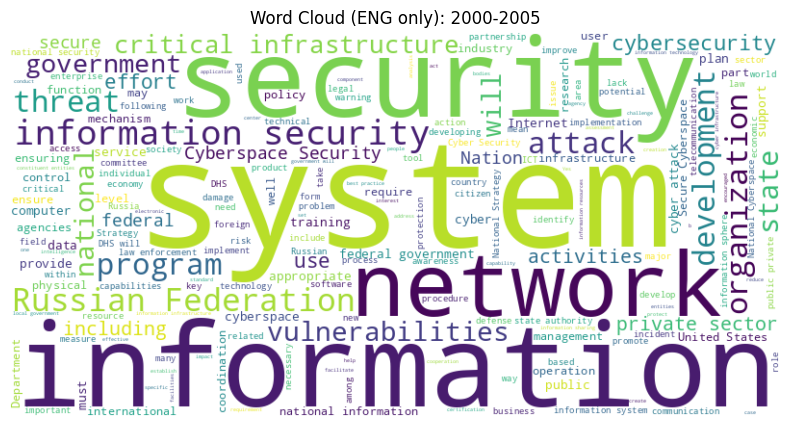

word_cloud_2006_2010


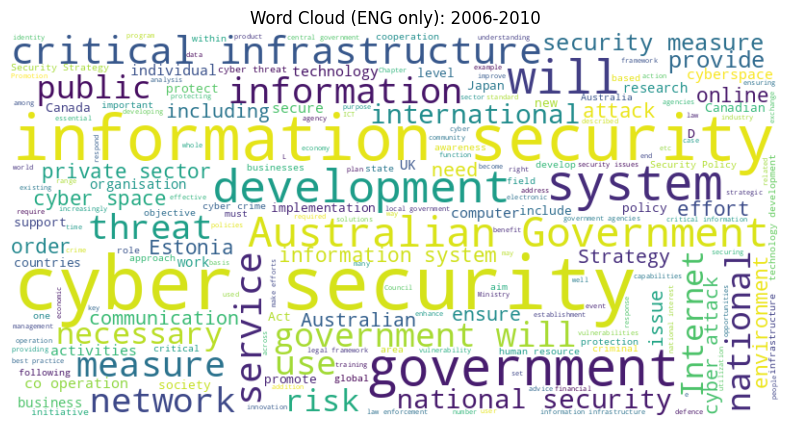

word_cloud_2011_2015


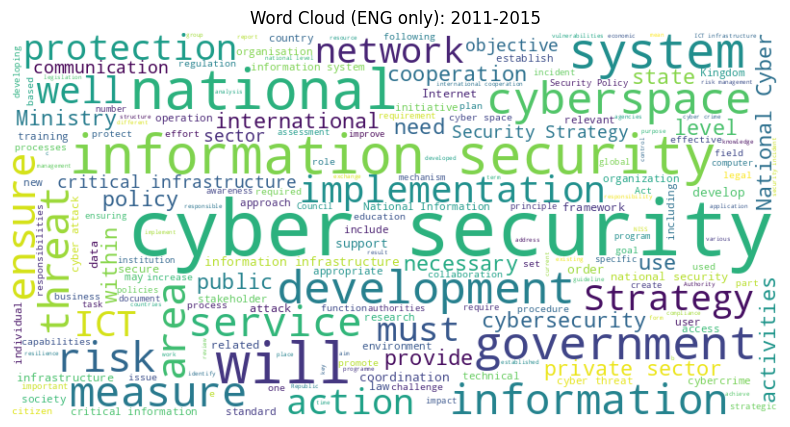

word_cloud_2019_2020


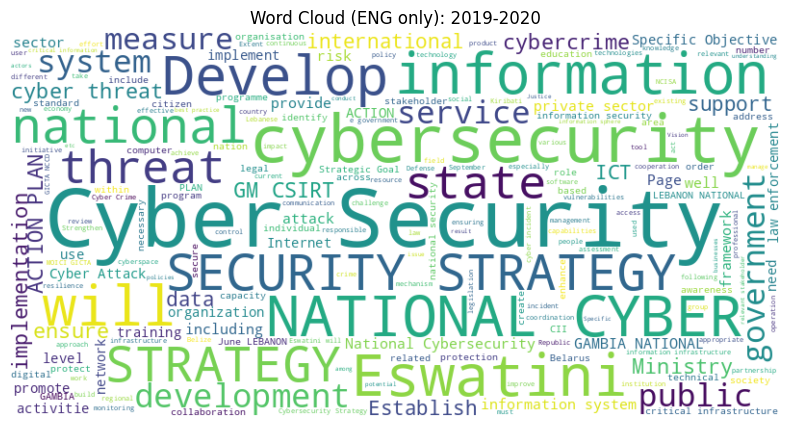

word_cloud_2021_2024


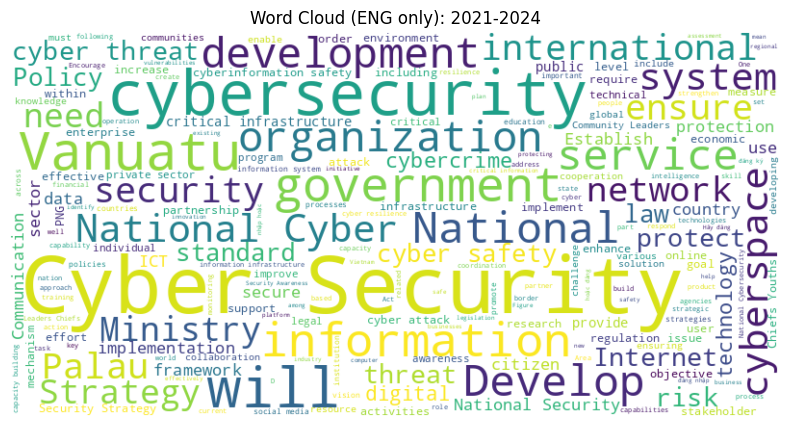

In [ ]:
# --- Step 5: Word Clouds for ENG only ---
# dataframe used: df_eng
time_ranges = {
    '2000-2005': (2000, 2005),
    '2006-2010': (2006, 2010),
    '2011-2015': (2011, 2015),
    '2019-2020': (2019, 2020),
    '2021-2024': (2021, 2024)
}

for label, (start, end) in time_ranges.items():
    subset = df_eng[(df_eng['year'] >= start) & (df_eng['year'] <= end)]
    if not subset.empty:
        combined_text = ' '.join(subset['content'].tolist())
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_text)

        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        print(f"word_cloud_{start}_{end}")
        plt.title(f"Word Cloud (ENG only): {label}")
        plt.show()

In [ ]:
pip install python-docx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.0/253.0 kB 7.8 MB/s eta 0:00:00


In [ ]:
import os
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from docx import Document  # for Word export

# --- Create folder if not exists ---
output_folder = "text_analysis_descriptives"
os.makedirs(output_folder, exist_ok=True)

# --- Define time ranges ---
time_ranges = {
    '2000-2005': (2000, 2005),
    '2006-2010': (2006, 2010),
    '2011-2015': (2011, 2015),
    '2019-2020': (2016, 2020),
    '2021-2024': (2021, 2024)
}

# --- Create Word Document for table ---
doc = Document()
doc.add_heading("Word Cloud Document Summary", level=1)

table = doc.add_table(rows=1, cols=3)
hdr_cells = table.rows[0].cells
hdr_cells[0].text = "Period"
hdr_cells[1].text = "Document Count"
hdr_cells[2].text = "Countries (Years)"

# --- Generate word clouds for each period ---
for label, (start, end) in time_ranges.items():
    subset = df_eng[(df_eng['year'] >= start) & (df_eng['year'] <= end)]

    if not subset.empty:
        combined_text = ' '.join(subset['content'].tolist())
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_text)

        # Save word cloud image (no title)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        filename = f"word_cloud_{start}_{end}.png"
        plt.savefig(os.path.join(output_folder, filename), bbox_inches='tight')
        plt.close()

        # Prepare country-year list
        country_years = [f"{row['country']} ({row['year']})" for _, row in subset.iterrows()]
        country_years_str = ", ".join(country_years)

        # Add row to Word table
        row_cells = table.add_row().cells
        row_cells[0].text = f"{start}-{end}"
        row_cells[1].text = str(len(subset))
        row_cells[2].text = country_years_str

# --- Create one "all periods" word cloud ---
subset_all = df_eng[(df_eng['year'] >= 2000) & (df_eng['year'] <= 2024)]
if not subset_all.empty:
    combined_text = ' '.join(subset_all['content'].tolist())
    wordcloud_all = WordCloud(width=800, height=400, background_color='white').generate(combined_text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud_all, interpolation='bilinear')
    plt.axis('off')
    filename = "word_cloud_2000_2024.png"
    plt.savefig(os.path.join(output_folder, filename), bbox_inches='tight')
    plt.close()

    # Add row for all-period summary
    country_years_all = [f"{row['country']} ({row['year']})" for _, row in subset_all.iterrows()]
    row_cells = table.add_row().cells
    row_cells[0].text = "2000-2024 (All)"
    row_cells[1].text = str(len(subset_all))
    row_cells[2].text = ", ".join(country_years_all)

# --- Save Word document ---
doc.save(os.path.join(output_folder, "wordcloud_summary.docx"))

In [ ]:
import shutil

# Zip the folder
shutil.make_archive("text_analysis_descriptives", 'zip', "text_analysis_descriptives")

# Download it
from google.colab import files
files.download("text_analysis_descriptives.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

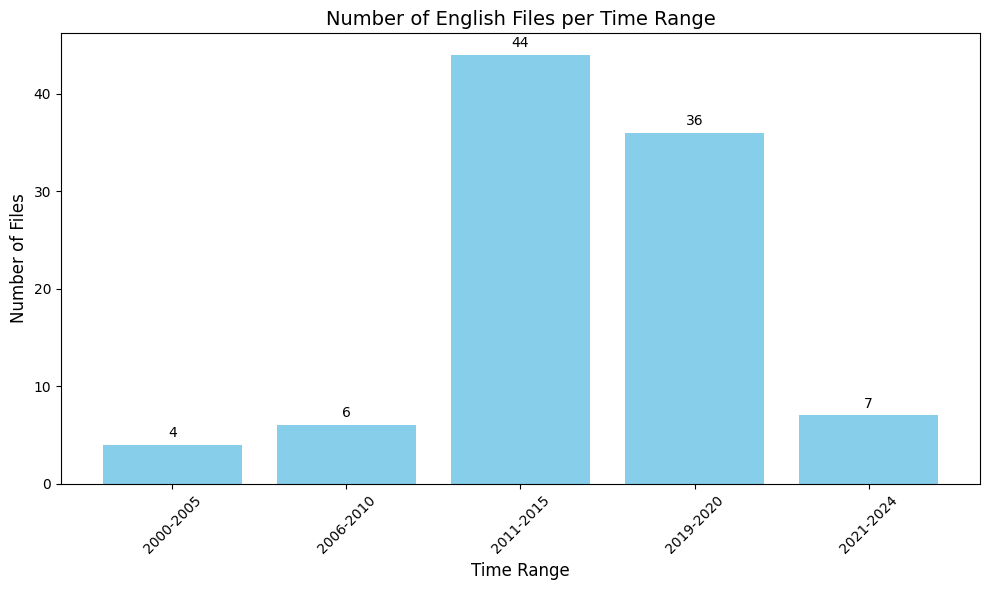

In [ ]:
import matplotlib.pyplot as plt

# Count number of files in each time range
time_counts = {}
for label, (start, end) in time_ranges.items():
    count = df_eng[(df_eng['year'] >= start) & (df_eng['year'] <= end)].shape[0]
    time_counts[label] = count

# Convert to lists for plotting
labels = list(time_counts.keys())
counts = list(time_counts.values())

# Plot bar chart with labels
plt.figure(figsize=(10, 6))
bars = plt.bar(labels, counts, color='skyblue')
plt.xlabel('Time Range', fontsize=12)
plt.ylabel('Number of Files', fontsize=12)
plt.title('Number of English Files per Time Range', fontsize=14)
plt.xticks(rotation=45)

# Annotate counts on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, str(height),
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


In [ ]:
# --- Step 6: Show language and year distribution ---

# Year distribution
# print(df['year'].value_counts().sort_index())
# print(df['language'].value_counts().sort_index())

import re

# Known language codes (from your counts)
LANG_CODES = ['ENG','ARA','BGR','DAN','ESP','FRA','FRN','GRC','KAZ','KOR','KYR','LTV','MKD','MON','NRW','POR','RUS','THA','TUR','UKR']

# --- Robust doc_id: remove a trailing _<LANG> token before underscore/dot/end ---
# e.g., "US_2020_STRAT_ENG.pdf" -> "US_2020_STRAT.pdf"
def strip_lang_token(fn: str) -> str:
    return re.sub(r'_(?:' + '|'.join(LANG_CODES) + r')(?=(_|\.|$))', '', str(fn))

df = df.copy()
df['doc_id'] = df['file_name'].map(strip_lang_token)

# --- Deduplicate with English priority ---
# eng_first=False for ENG, True for others → ENG sorts first within each doc_id
df_unique = (
    df.assign(eng_first=(df['language'] != 'ENG'))
      .sort_values(['doc_id', 'eng_first', 'year'], ascending=[True, True, False])
      .drop_duplicates(subset='doc_id', keep='first')
)
# Now use df_unique for BOTH plots so:
#  - Language distribution counts ENG if a doc exists in both ENG + native (native excluded)
#  - Year distribution doesn't double-count multi-language docs

In [ ]:
df_unique

,file_name,year,month,day,language,content,doc_id,eng_first
28,20000909_Russia_National Cybersecurity Strateg...,2000,9,9,ENG,INFORMATION SECURITY DOCTRINE OF THE RUSSIAN F...,20000909_Russia_National Cybersecurity Strateg...,False
24,20030201_USA_National Cybersecurity Strategy_E...,2003,2,1,ENG,010101110101011110 0 0111010101101101010101011...,20030201_USA_National Cybersecurity Strategy.txt,False
132,20031105_Tajikistan_National Cybersecurity Str...,2003,11,5,ENG,PRESIDENTIAL DECREE OF THE REPUBLIC OF TAJIKIS...,20031105_Tajikistan_National Cybersecurity Str...,False
53,20050101_Philippines_National Cybersecurity St...,2005,1,1,ENG,Philippine National Cyber Security Plan 2005 E...,20050101_Philippines_National Cybersecurity St...,False
116,20060101_Malaysia_National Cybersecurity Strat...,2006,1,1,ENG,\n\nNational Cyber Security\n©Ministry of Scie...,20060101_Malaysia_National Cybersecurity Strat...,False
...,...,...,...,...,...,...,...,...
31,20221201_Niger_National Cybersecurity Strategy...,2022,12,1,FRN,Niger-Technologies-information\nLe Niger se do...,20221201_Niger_National Cybersecurity Strategy...,True
12,20240101_Togo_National Cybersecurity Strategy_...,2024,1,1,FRN,Stratégie Nationale de SHHHIE\n\n2024-2028 |\n...,20240101_Togo_National Cybersecurity Strategy.txt,True
104,20240404_Papua New Guinea_National Cybersecuri...,2024,4,4,ENG,\nTHE INDEPENDENT STATE OF PAPUA NEW GUINEA\nN...,20240404_Papua New Guinea_National Cybersecuri...,False
91,20240528_Argentina_National Cybersecurity Stra...,2024,5,28,ESP,ESTRATEGIA NACIONAL DE CIBERSEGURIDAD DE LA RE...,20240528_Argentina_National Cybersecurity Stra...,True


In [ ]:
df_unique['language'].value_counts()

,count
language,
ENG,99
FRN,12
ESP,8
ARA,3
POR,2
RUS,2
LTV,1
UKR,1
FRA,1


In [ ]:
year_counts = df_unique['year'].value_counts().sort_index()

plt.figure(figsize=(8,4))
year_counts.plot(kind='bar', color='black', edgecolor='black')
plt.xlabel("Year")
plt.ylabel("Number of Documents")
plt.xticks(rotation=45)
plt.title("")  # remove title
plt.savefig("number_of_strategies_over_time.png", bbox_inches='tight')
plt.close()

print("Saved: language_distribution.png and number_of_strategies_over_time.png")

Saved: language_distribution.png and number_of_strategies_over_time.png


In [ ]:
lang_counts = df_unique['language'].value_counts()

plt.figure(figsize=(6,4))
lang_counts.plot(kind='bar', color='grey', edgecolor='black')
plt.xlabel("Language")
plt.ylabel("Number of Documents")
plt.xticks(rotation=45)
plt.title("")  # remove title
plt.savefig("language_distribution.png", bbox_inches='tight')
plt.close()

In [ ]:
# --- Step 5: Function to compare two documents ---
def compare_documents(file1, file2):
    doc1 = df.loc[df['file_name'] == file1, 'content'].values
    doc2 = df.loc[df['file_name'] == file2, 'content'].values

    if len(doc1) == 0 or len(doc2) == 0:
        print("One or both files not found.")
        return

    doc1 = doc1[0]
    doc2 = doc2[0]

    # TF-IDF Cosine Similarity
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = vectorizer.fit_transform([doc1, doc2])
    cosine_sim = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])[0][0]

    results = {
        'cosine_similarity': float(cosine_sim)
    }

    return results

# --- Example: Compare two documents ---
file_a = '20200601_Gambia_National Cybersecurity Strategy_ENG.txt'
file_b = '20170101_Thailand_National Cybersecurity Strategy_ENG.txt'

comparison = compare_documents(file_a, file_b)
print("Comparison Results:", comparison)

Comparison Results: {'cosine_similarity': 0.6012188607172216}


In [ ]:
# df_unique['language'].value_counts()
df_unique['country'] = df_unique['file_name'].apply(lambda x: x.split('_')[1] if '_' in x else None)
df_unique['country'].unique()

array(['Russia', 'USA', 'Tajikistan', 'Philippines', 'Malaysia', 'Japan',
       'Estonia', 'Australia', 'United Kingdom', 'Canada', 'Burkina Faso',
       'Czech Republic', 'France', 'Luxembourg', 'Netherlands', 'Germany',
       'New Zealand', 'Lithuania', 'Colombia', 'South Korea', 'Georgia',
       'Jordan', 'Cyprus', 'Switzerland', 'Chad', 'Belgium',
       'Trinidad and Tobago', 'Morocco', 'Norway', 'Finland', 'India',
       'Romania', 'Saudi Arabia', 'Spain', 'Turkey', 'Austria', 'Hungary',
       'Poland', 'Montenegro', 'Italy', 'Portugal', 'Bangladesh',
       'Latvia', 'Mauritius', 'Syria', 'Kenya', 'Uruguay', 'Qatar',
       'Afghanistan', 'Uganda', 'Denmark', 'Nigeria', 'Albania',
       'Ireland', 'Jamaica', 'Malta', 'Slovakia', 'Rwanda', 'Brazil',
       'Iceland', 'Peru', 'Ghana', 'Botswana', 'Croatia', 'Moldova',
       'South Africa', 'Samoa', 'Singapore', 'Slovenia', 'Uzbekistan',
       'Ukraine', 'Tanzania', 'Bulgaria', 'Nepal', 'Mozambique',
       'Sierra Leone',

In [ ]:
# List of countries to check
five_eyes = [
    "Australia",
    "Canada",
    "New Zealand",
    "United Kingdom",
    "USA",
]

sco = [
    "Belarus",
    "China",
    "India",
    "Iran",
    "Kazakhstan",
    "Kyrgyzstan",
    "Pakistan",
    "Russia",
    "Tajikistan",
    "Uzbekistan",
]

selected_countries = five_eyes + sco

# --- Step 1: Check Five Eyes countries ---
five_eyes_eng = df_unique[(df_unique['country'].isin(five_eyes)) & (df_unique['language'] == 'ENG')]
print("Five Eyes English docs:")
print(five_eyes_eng[['country','file_name','year']].head())

# --- Step 2: Check SCO countries ---
sco_eng = df_unique[(df_unique['country'].isin(sco)) & (df_unique['language'] == 'ENG')]
print("\nSCO English docs:")
print(sco_eng[['country','file_name','year']].head())

# --- Step 3: Summary counts ---
print("\nSummary:")
print("Five Eyes ENG count:", len(five_eyes_eng))
print("SCO ENG count:", len(sco_eng))

Five Eyes English docs:
            country                                          file_name  year
24              USA  20030201_USA_National Cybersecurity Strategy_E...  2003
128       Australia  20090101_Australia_National Cybersecurity Stra...  2009
122  United Kingdom  20090601_United Kingdom_National Cybersecurity...  2009
134          Canada  20101003_Canada_National Cybersecurity Strateg...  2010
70      New Zealand  20110601_New Zealand_National Cybersecurity St...  2011

SCO English docs:
        country                                          file_name  year
28       Russia  20000909_Russia_National Cybersecurity Strateg...  2000
132  Tajikistan  20031105_Tajikistan_National Cybersecurity Str...  2003
50        India  20130101_India_National Cybersecurity Strategy...  2013
78        China  20161227_China_National Cybersecurity Strategy...  2016
54      Belarus  20190101_Belarus_National Cybersecurity Strate...  2019

Summary:
Five Eyes ENG count: 5
SCO ENG count: 6


In [ ]:
selected_countries_eng = sco_eng['country'].tolist() + five_eyes_eng['country'].tolist()
print(selected_countries_eng)

['Russia', 'Tajikistan', 'India', 'China', 'Belarus', 'Pakistan', 'USA', 'Australia', 'United Kingdom', 'Canada', 'New Zealand']


In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
import random
import seaborn as sns
import numpy as np

country_texts = {}
for country in selected_countries_eng:
    combined_text = ' '.join(df_unique[df_unique['country'] == country]['content'].tolist())
    country_texts[country] = combined_text

import re
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

# --- 1. Cleaning function with lemmatization and boilerplate removal ---
lemmatizer = WordNetLemmatizer()
custom_stopwords = ['this report', 'confidential', 'introduction', 'conclusion']

def clean_text(text):
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+|\S+@\S+', '', text)  # remove links/emails
    text = re.sub(r'\d+', '', text)                             # remove numbers
    text = re.sub(r'[^a-z\s]', ' ', text)                      # remove punctuation/special chars
    text = re.sub(r'\s+', ' ', text).strip()                  # remove extra spaces

    # Lemmatization
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

    # Remove custom boilerplate phrases
    for phrase in custom_stopwords:
        text = text.replace(phrase, '')

    return text

# Clean all documents
cleaned_texts = {k: clean_text(v) for k, v in country_texts.items()}
cleaned_texts

{'Russia': 'information security doctrine of the russian federation approved by president of the russian federation vladimir putin on september the information security doctrine of the russian federation represents a totality of official view on the goal objective principle and basic guideline for ensuring information security in the russian federation the present doctrine serf a the basis for shaping government policy on information security in the russian federation preparing suggestion to improve the legal procedural scientific technical and organizational framework for ensuring information security in the russian federation devising targeted national information security program the present doctrine expounds the national security concept of the russian federation a applied to the information sphere i information security of the russian federation the national interest of the russian federation in the information sphere and how they are to be secured the present stage in societal de

In [ ]:
# --- 2. TF-IDF Cosine Similarity ---
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(cleaned_texts.values())
tfidf_cosine = cosine_similarity(tfidf_matrix)

# --- 3. Embedding Cosine Similarity ---
model = SentenceTransformer('all-MiniLM-L6-v2')  # light-weight model for semantic similarity
embeddings = model.encode(list(cleaned_texts.values()), convert_to_tensor=True)
embedding_cosine = cosine_similarity(embeddings)

# --- 4. Convert to DataFrames for heatmap visualization ---
labels = list(cleaned_texts.keys())
tfidf_df = pd.DataFrame(tfidf_cosine, index=labels, columns=labels)
embedding_df = pd.DataFrame(embedding_cosine, index=labels, columns=labels)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

TF-IDF Cosine Similarity


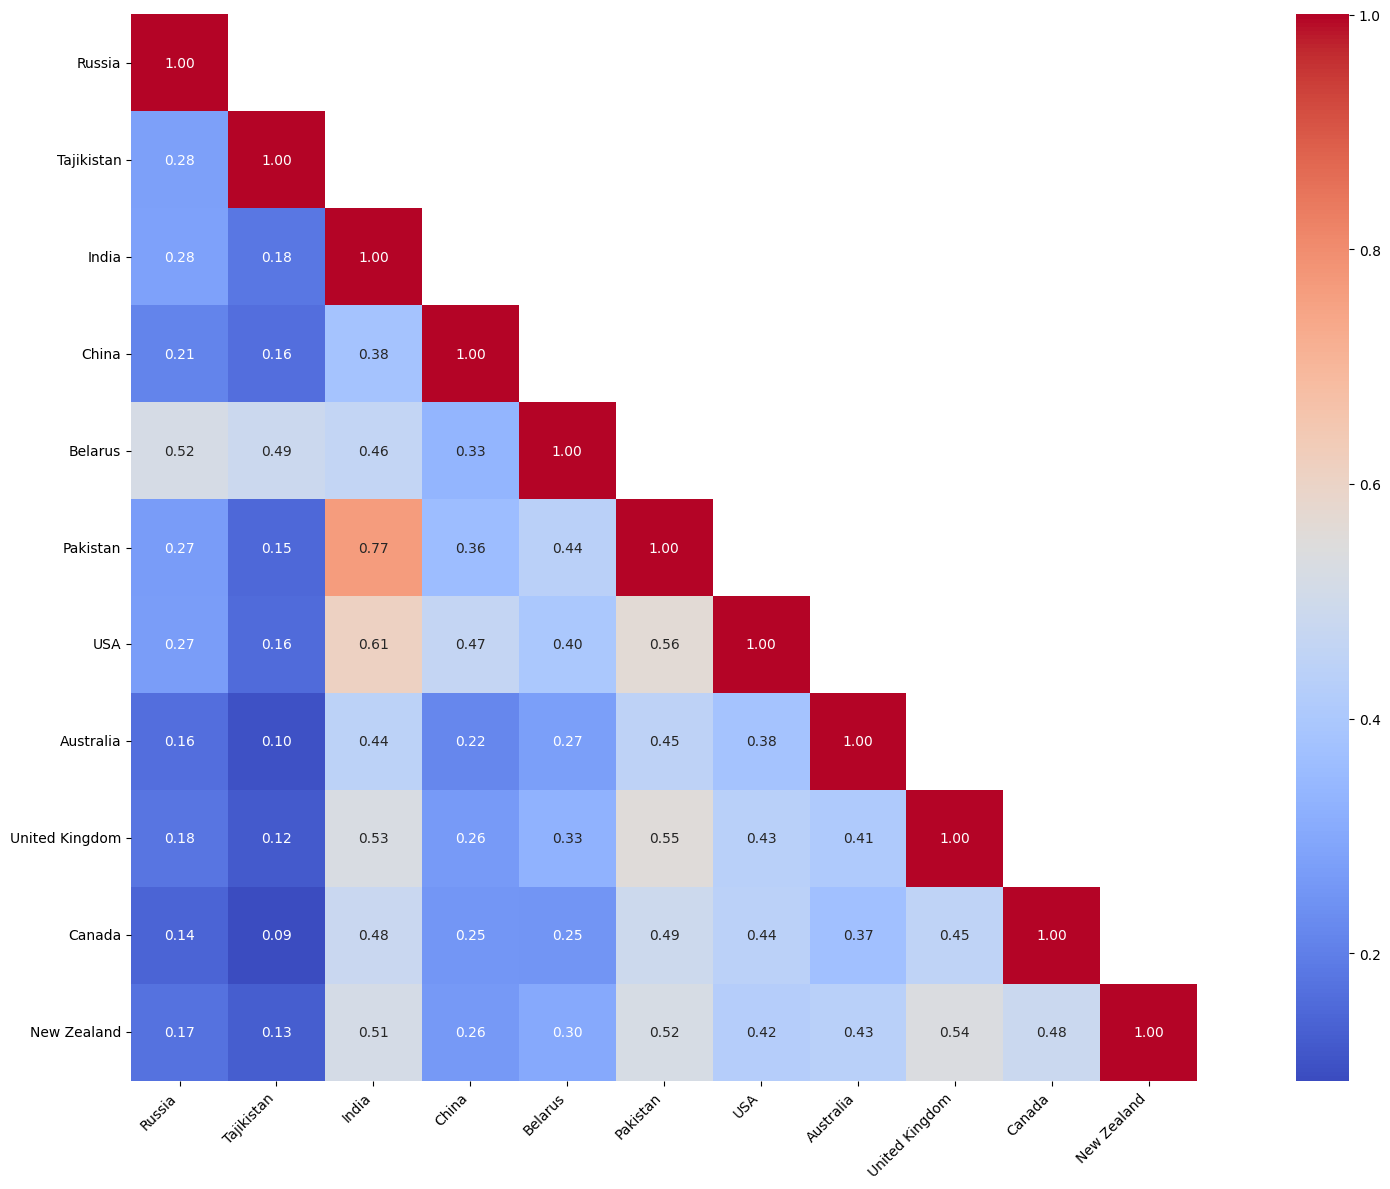

Semantic Embedding Cosine Similarity


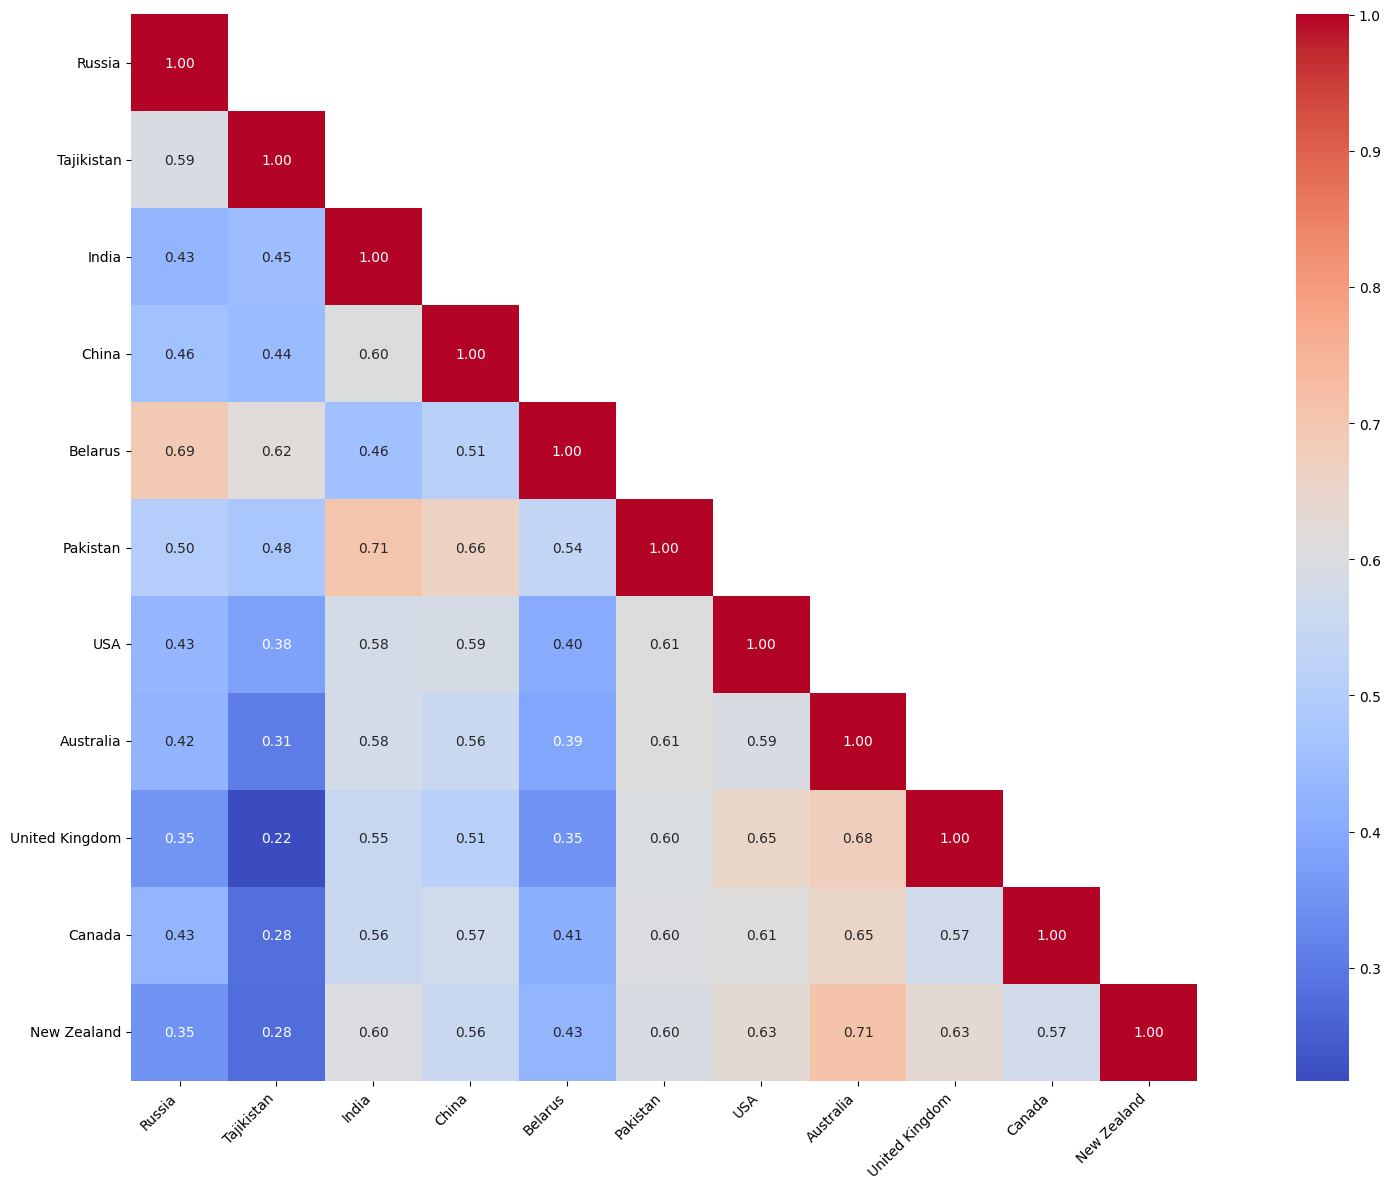

In [ ]:
# --- 5. Plot heatmaps ---
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Create a mask for the upper triangle ---
mask = np.triu(np.ones_like(tfidf_df, dtype=bool), k=1)

# --- TF-IDF Cosine Similarity Heatmap ---
plt.figure(figsize=(20, 12))
sns.heatmap(tfidf_df, cmap='coolwarm', annot=True, fmt=".2f", cbar=True, square=True, mask=mask)
print('TF-IDF Cosine Similarity')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.savefig("TF-IDF Cosine Similarity.png", bbox_inches='tight')
plt.show()
plt.close()

# --- Semantic Embedding Cosine Similarity Heatmap ---
mask2 = np.triu(np.ones_like(embedding_df, dtype=bool), k=1)

plt.figure(figsize=(20, 12))
sns.heatmap(embedding_df, cmap='coolwarm', annot=True, fmt=".2f", cbar=True, square=True, mask=mask2)
print('Semantic Embedding Cosine Similarity')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.savefig("Semantic Embedding Cosine Similarity.png", bbox_inches='tight')
plt.show()
plt.close()
